<a href="https://colab.research.google.com/github/dean-daryl/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re

import pandas as pd
import kagglehub
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
# Download dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset downloaded to:", path)

# The CSV file in the downloaded directory is 'IMDB Dataset.csv'
csv_path = os.path.join(path, "IMDB Dataset.csv")


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Dataset downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Load dataset into a pandas DataFrame
df = pd.read_csv(csv_path)

In [ ]:
# Preview data
print("Dataset shape:", df.shape)  # Should be (50000, 2)
print(df.head())  # Shows first 5 rows: 'review' and 'sentiment' columns

Dataset shape: (49582, 4)
                                              review sentiment  review_length  \
0  One of the other reviewers has mentioned that ...  positive           1761   
1  A wonderful little production. <br /><br />The...  positive            998   
2  I thought this was a wonderful way to spend ti...  positive            926   
3  Basically there's a family where a little boy ...  negative            748   
4  Petter Mattei's "Love in the Time of Money" is...  positive           1317   

                                      cleaned_review  
0  one reviewers mentioned watching oz episode yo...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically theres family little boy jake thinks...  
4  petter matteis love time money visually stunni...  


In [ ]:
print("Dataset Info:")
print(df.info())  # Shows data types, non-null counts

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [ ]:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())  # Should be balanced: ~25K each


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [ ]:
# Checking for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
review            0
sentiment         0
review_length     0
cleaned_review    0
dtype: int64


In [ ]:
# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
0


In [ ]:
# Handle duplicates
df = df.drop_duplicates()  # Remove duplicates

In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


## Visualizations

/tmp/ipython-input-2893965689.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


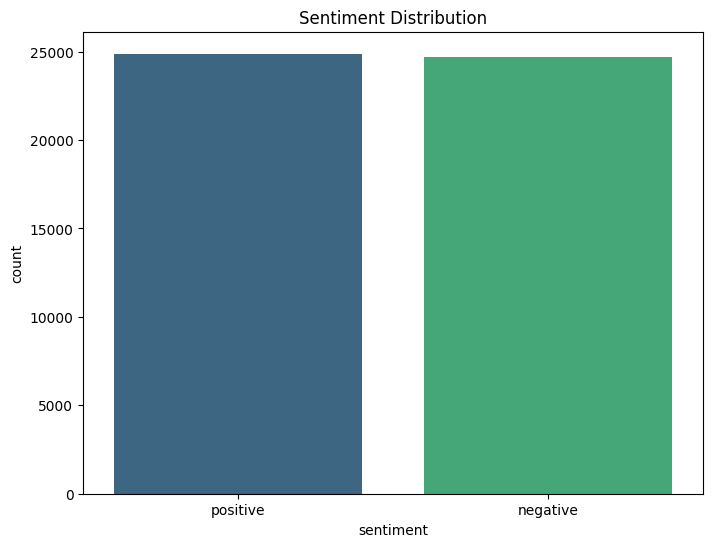

In [ ]:
# Sentiment Distribution (bar plot)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.savefig('sentiment_distribution.png')
plt.show()
plt.close()

For training a sentiment analysis model, having a balanced dataset is key. If the dataset is highly imbalanced, our model might become biased towards the majority class, leading to poor performance on the minority class.

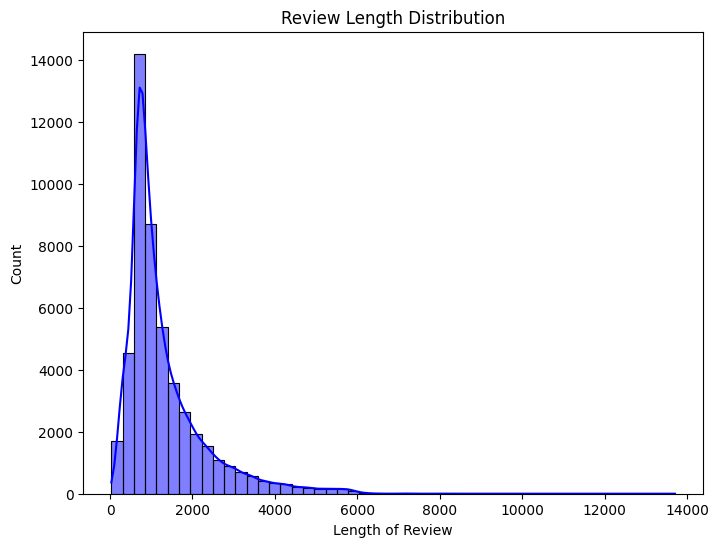

In [ ]:
# Review Length Distribution (histogram)
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.xlabel('Length of Review')
plt.savefig('review_length_distribution.png')
plt.show()
plt.close()

/tmp/ipython-input-1675635104.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')


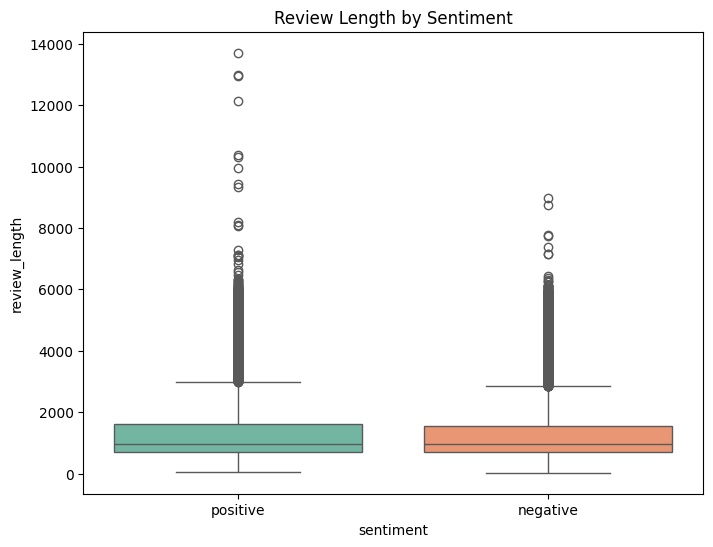

In [ ]:
# Boxplot of Review Length by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')
plt.title('Review Length by Sentiment')
plt.savefig('review_length_by_sentiment.png')
plt.show()
plt.close()

In [ ]:
# Word Clouds for Positive and Negative Reviews
stop_words = set(nltk.corpus.stopwords.words('english'))
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

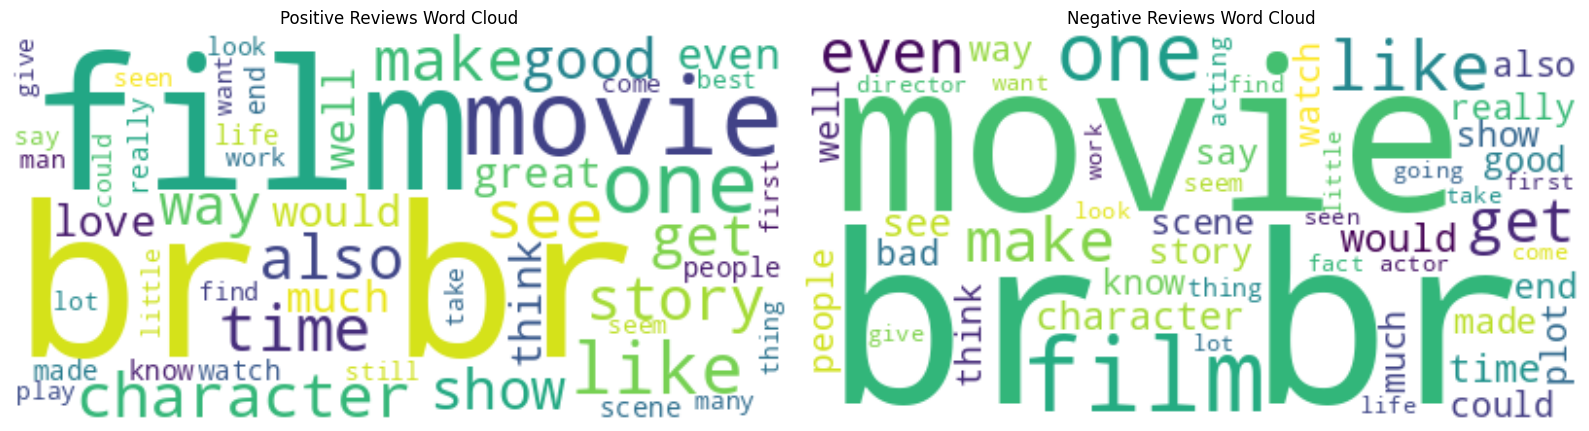

In [ ]:
# Positive Word Cloud
wordcloud_pos = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(positive_text)

# Negative Word Cloud
wordcloud_neg = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews Word Cloud')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Reviews Word Cloud')

plt.tight_layout()
plt.savefig('wordclouds_side_by_side.png')
plt.show()
plt.close()

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<br />', ' ', text)  # Remove HTML tags (common in IMDB)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars/numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Applying preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [ ]:
print(df)

                                                  review sentiment  \
0      One of the other reviewers has mentioned that ...  positive   
1      A wonderful little production. <br /><br />The...  positive   
2      I thought this was a wonderful way to spend ti...  positive   
3      Basically there's a family where a little boy ...  negative   
4      Petter Mattei's "Love in the Time of Money" is...  positive   
...                                                  ...       ...   
49995  I thought this movie did a down right good job...  positive   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative   
49997  I am a Catholic taught in parochial elementary...  negative   
49998  I'm going to have to disagree with the previou...  negative   
49999  No one expects the Star Trek movies to be high...  negative   

       review_length                                     cleaned_review  
0               1761  one reviewers mentioned watching oz episode yo...  
1          

In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X = df['cleaned_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Binary labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Engineering

In [ ]:
# For ML: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# For DL: Tokenization and Padding (with basic embeddings)
max_words = 5000
max_len = 200  # Based on EDA, truncate/pad to average length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
print("Preprocessing completed. Data shapes:", X_train_tfidf.shape, X_train_pad.shape)

Preprocessing completed. Data shapes: (39665, 5000) (39665, 200)


## ML Model: Logistic Regression

In [ ]:
# ML Model: Logistic Regression
def train_logistic_regression(X_train, X_test, y_train, y_test, params):
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm

## DL Model: LSTM

In [ ]:
# DL Model: LSTM
def train_lstm(X_train, X_test, y_train, y_test, params):
    model = Sequential([
        Embedding(input_dim=params['max_words'], output_dim=128, input_length=params['max_len']),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.2, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm, history

## Experiment 1: Logistic Regression

In [ ]:
# Experiment 1: Logistic Regression (vary C)
lr_experiments = [
    {'C': 0.1, 'max_iter': 1000},
    {'C': 1.0, 'max_iter': 1000},
    {'C': 10.0, 'max_iter': 1000}
]
lr_results = []
for params in lr_experiments:
    _, acc, f1, _ = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, params)
    lr_results.append({'C': params['C'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lr_results).to_csv('lr_experiment_results.csv', index=False)

## Experiment 2: LSTM

In [ ]:
# Experiment 2: LSTM (vary epochs, batch_size, optimizer)
lstm_experiments = [
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'rmsprop'}
]
lstm_results = []
for params in lstm_experiments:
    _, acc, f1, _, _ = train_lstm(X_train_pad, X_test_pad, y_train, y_test, params)
    lstm_results.append({'Epochs': params['epochs'], 'Batch Size': params['batch_size'],
                         'Optimizer': params['optimizer'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lstm_results).to_csv('lstm_experiment_results.csv', index=False)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 146s 144ms/step - accuracy: 0.7940 - loss: 0.4304 - val_accuracy: 0.8698 - val_loss: 0.3050
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 144s 145ms/step - accuracy: 0.9031 - loss: 0.2442 - val_accuracy: 0.8766 - val_loss: 0.2897
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 144s 145ms/step - accuracy: 0.9251 - loss: 0.1946 - val_accuracy: 0.8747 - val_loss: 0.3276
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 135s 268ms/step - accuracy: 0.7740 - loss: 0.4637 - val_accuracy: 0.8763 - val_loss: 0.2971
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - accuracy: 0.9076 - loss: 0.2443 - val_accuracy: 0.8784 - val_loss: 0.2901
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 132s 267ms/step - accuracy: 0.9279 - loss: 0.1926 - val_accuracy: 0.8707 - val_loss: 0.3163
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 141s 266ms/step - accuracy: 0.9423 - loss: 0.1605 - val_accuracy: 0.8656 - val_loss: 0.3476
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 131s 265ms/step - accuracy: 0.9557 - loss: 0.1251 - val_accuracy: 0.8526 - val_loss: 0.3828
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 149s 147ms/step - accuracy: 0.7808 - loss: 0.4565 - val_accuracy: 0.8646 - val_loss: 0.3174
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 202s 147ms/step - accuracy: 0.8967 - loss: 0.2657 - val_accuracy: 0.8820 - val_loss: 0.3218
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 200s 145ms/step - accuracy: 0.9103 - loss: 0.2360 - val_accuracy: 0.8669 - val_loss: 0.3049
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


In [ ]:
print("Experiments completed. Results in CSVs.")

Experiments completed. Results in CSVs.


##Final Evaluations

In [ ]:
# Assume best params from experiments (e.g., C=1.0 for LR, first LSTM config)
# Final LR Evaluation
lr_params = {'C': 1.0, 'max_iter': 1000}
_, lr_acc, lr_f1, lr_cm = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, lr_params)

In [ ]:
# Final LSTM Evaluation
lstm_params = {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'}
_, lstm_acc, lstm_f1, lstm_cm, history = train_lstm(X_train_pad, X_test_pad, y_train, y_test, lstm_params)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 148s 146ms/step - accuracy: 0.7888 - loss: 0.4304 - val_accuracy: 0.8710 - val_loss: 0.3031
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 144s 146ms/step - accuracy: 0.9078 - loss: 0.2408 - val_accuracy: 0.8776 - val_loss: 0.2958
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 145s 146ms/step - accuracy: 0.9268 - loss: 0.1906 - val_accuracy: 0.8683 - val_loss: 0.3712
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


In [ ]:
# Plot Confusion Matrices
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.show()
    plt.close()

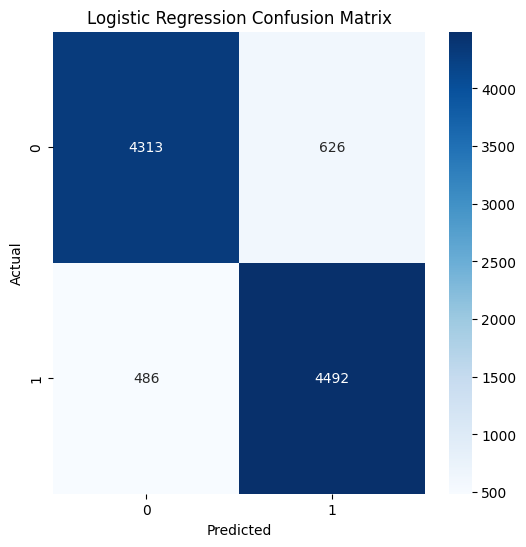

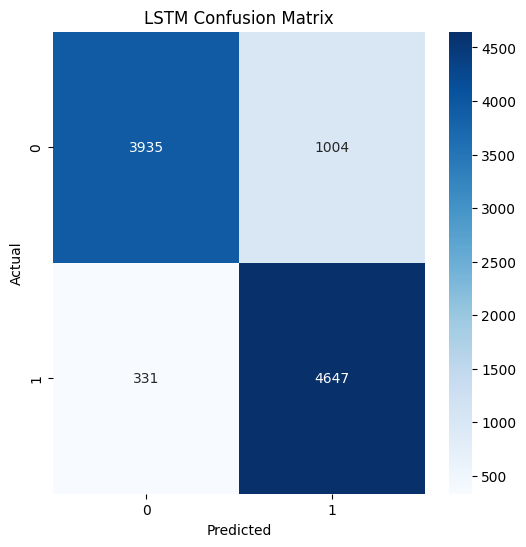

In [ ]:
plot_confusion_matrix(lr_cm, 'Logistic Regression Confusion Matrix', 'lr_cm.png')
plot_confusion_matrix(lstm_cm, 'LSTM Confusion Matrix', 'lstm_cm.png')

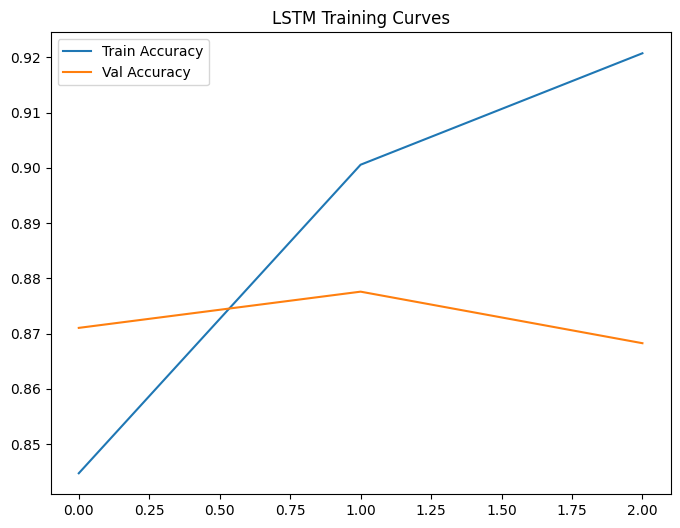

In [ ]:
# Plot LSTM Training History
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Training Curves')
plt.legend()
plt.savefig('lstm_training_curves.png')
plt.show()
plt.close()

In [ ]:
# Print Metrics
print("LR: Acc=", lr_acc, "F1=", lr_f1)
print("LSTM: Acc=", lstm_acc, "F1=", lstm_f1)

LR: Acc= 0.8878693153171322 F1= 0.8898573692551506
LSTM: Acc= 0.8653826762125643 F1= 0.8744002257973469
